In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [4]:
#reload modules
%load_ext autoreload
%autoreload 2

In [5]:
import join_data as jd

In [6]:
from helpers import *

In [7]:
# filesavelabel = 'publicdatacategory_'
# predicted_delays_filename = './data_est_report_delays/category_borough_interaction_model_delays.csv'

filesavelabel = 'publicdatarisk_'
predicted_delays_filename = './data_est_report_delays/risk_borough_interaction_model_delays.csv'

# Load and join the public data

In [8]:
mergeddfpublic = jd.pipeline(directory = '../data/', FSfilename = 'FSR_221022.csv', FIfilename = 'FI_221022.csv', FWOfilename = 'FWO_221022.csv', FRAfilename = 'FRA_221024.csv')

In [9]:
mergeddfpublic.columns

Index(['OBJECTID', 'SRCategory', 'SRType', 'SRPriority', 'SRSource',
       'SRStatus', 'SRResolution', 'Borough', 'CommunityBoard',
       'ServiceRequestParentGlobalID', 'GlobalID', 'InitiatedDate',
       'SRClosedDate', 'SRCreatedDate', 'SRUpdatedDate', 'Descriptor1',
       'ComplaintType', 'CallerZipCode', 'SRCallerType', 'Latitude',
       'Longitude', 'Census Tract', 'NTA', 'SRGlobalID', 'InspectionType',
       'InspectionStatus', 'InspectionTPCondition', 'InspectionTPStructure',
       'TreePointDBH', 'InsGlobalID', 'InspectionDate', 'InsClosedDate',
       'InsCreatedDate', 'InsUpdatedDate', 'ParentInspectionGlobalID',
       'ReinspectionDate', 'Location', 'WOType', 'WOStatus', 'WOPriority',
       'ActualFinishDate', 'CancelReason', 'WOCategory', 'WOGlobalID',
       'WOClosedDate', 'CancelDate', 'WOCreatedDate', 'WOUpdatedDate',
       'WOEntity', 'PROJSTARTDATE', 'WOProject', 'RecommendedSpecies',
       'Location_WO', 'RADefect', 'RADefectLocation', 'Failure',
       'I

### Load + join model estimates for reporting delays

We have a dataframe where we have predicted report delays for many incidents (that were used to train the model). We also want to have predicted reporting delays for other incidents. So what we will do is extract coefficients from that dataframe (we can do this perfectly except for Bayesian noise) and apply the model to all the incidents.

In [10]:
predicted_report_delays = pd.read_csv(predicted_delays_filename)
predicted_report_delays = predicted_report_delays.rename(columns = {'SRID': 'OBJECTID', 'delay': 'reporting_delay'})

In [11]:
predicted_report_delays.head()

,OBJECTID,Borough,CommunityBoard,Category,type,SRCreatedDate,SRClosedDate,death_time,TruncDuration,Duration,reporting_delay
0,17944200,Brooklyn,318.0,Hazard,Limb Down - Sidewalk,2020-06-30 03:03:00,2020-07-08 00:40:00,2020-06-30 15:20:00,0.511806,0.511806,11.34330
1,12185633,Staten Island,502.0,Remove Tree,Dead Tree Older Than 2 Years,2018-08-15 23:42:00,2019-04-02 02:24:43,2018-08-21 11:33:50,5.494329,5.494329,16.52310
2,13020663,Queens,408.0,Remove Tree,Poor Condition Cracked,2018-11-01 15:45:00,2018-11-05 10:58:19,2018-11-05 10:57:52,3.800602,3.800602,48.06360
3,12105835,Queens,410.0,Hazard,Limb Down - Other,2018-07-28 01:51:00,2018-08-01 18:21:00,2018-07-28 09:44:42,0.328958,0.328958,5.43021
4,11573966,Queens,403.0,Root/Sewer/Sidewalk,Sidewalk Consultation,2018-06-01 17:51:00,2018-06-29 14:30:00,2018-06-28 04:00:00,26.422917,26.422917,74.27160


In [12]:
predicted_report_delays_joinedwithfeatures = pd.merge(predicted_report_delays, mergeddfpublic, on='OBJECTID', how='left', suffixes=('', '_public')).drop_duplicates(subset = 'OBJECTID')

In [13]:
predicted_report_delays.count()

OBJECTID           80981
Borough            80981
CommunityBoard     80981
Category           80981
type               80981
SRCreatedDate      80981
SRClosedDate       79155
death_time         80981
TruncDuration      80981
Duration           80981
reporting_delay    80981
dtype: int64

In [14]:
predicted_report_delays_joinedwithfeatures.count()

OBJECTID               80981
Borough                80981
CommunityBoard         80981
Category               80981
type                   80981
                       ...  
WorkOrderGlobalID      20475
IncidentGlobalID       80981
inspection_attached    80981
wo_attached            80981
Risk_coded             80981
Length: 77, dtype: int64

In [15]:
#statsmodels from formula import
import statsmodels.formula.api as smf

In [16]:
predicted_report_delays_joinedwithfeatures.columns

Index(['OBJECTID', 'Borough', 'CommunityBoard', 'Category', 'type',
       'SRCreatedDate', 'SRClosedDate', 'death_time', 'TruncDuration',
       'Duration', 'reporting_delay', 'SRCategory', 'SRType', 'SRPriority',
       'SRSource', 'SRStatus', 'SRResolution', 'Borough_public',
       'CommunityBoard_public', 'ServiceRequestParentGlobalID', 'GlobalID',
       'InitiatedDate', 'SRClosedDate_public', 'SRCreatedDate_public',
       'SRUpdatedDate', 'Descriptor1', 'ComplaintType', 'CallerZipCode',
       'SRCallerType', 'Latitude', 'Longitude', 'Census Tract', 'NTA',
       'SRGlobalID', 'InspectionType', 'InspectionStatus',
       'InspectionTPCondition', 'InspectionTPStructure', 'TreePointDBH',
       'InsGlobalID', 'InspectionDate', 'InsClosedDate', 'InsCreatedDate',
       'InsUpdatedDate', 'ParentInspectionGlobalID', 'ReinspectionDate',
       'Location', 'WOType', 'WOStatus', 'WOPriority', 'ActualFinishDate',
       'CancelReason', 'WOCategory', 'WOGlobalID', 'WOClosedDate',
       

In [17]:
cols = ['SRCategory', 'Borough', 'RiskRating', 'InspectionTPCondition', 'TreePointDBH']

predicted_report_delays_joinedwithfeatures.loc[:, 'reporting_rate'] = predicted_report_delays_joinedwithfeatures.eval('1/reporting_delay')

predicted_report_delays_joinedwithfeatures.loc[:, 'log_reporting_rate'] = predicted_report_delays_joinedwithfeatures.eval('log(1/reporting_delay)')


#regress reporting delay on category, borough, and risk
model = smf.ols(formula='log_reporting_rate ~ 1 + C(SRCategory) + C(Borough) + C(Risk_coded) + C(Borough):C(Risk_coded) + InspectionTPCondition + np.log(TreePointDBH + 1)', data=predicted_report_delays_joinedwithfeatures).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     log_reporting_rate   R-squared:                       0.994
Model:                            OLS   Adj. R-squared:                  0.994
Method:                 Least Squares   F-statistic:                 3.795e+05
Date:                Tue, 29 Aug 2023   Prob (F-statistic):               0.00
Time:                        08:55:36   Log-Likelihood:                 77270.
No. Observations:               79893   AIC:                        -1.545e+05
Df Residuals:                   79854   BIC:                        -1.541e+05
Df Model:                          38                                         
Covariance Type:            nonrobust                                         
========================================================================================================================
                                                           coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
Intercept                                               -0.8329      0.010    -83.846      0.000      -0.852      -0.813
C(SRCategory)[T.Illegal Tree Damage]                    -1.2568      0.002   -822.193      0.000      -1.260      -1.254
C(SRCategory)[T.Prune]                                  -1.5352      0.001  -1367.126      0.000      -1.537      -1.533
C(SRCategory)[T.Remove Tree]                            -1.4245      0.001  -1562.678      0.000      -1.426      -1.423
C(SRCategory)[T.Root/Sewer/Sidewalk]                    -3.1666      0.001  -3145.440      0.000      -3.169      -3.165
C(Borough)[T.Brooklyn]                                  -0.3721      0.015    -24.485      0.000      -0.402      -0.342
C(Borough)[T.Manhattan]                                  0.6942      0.014     49.155      0.000       0.667       0.722
C(Borough)[T.Queens]                                    -0.5936      0.010    -60.214      0.000      -0.613      -0.574
C(Borough)[T.Staten Island]                              0.0478      0.014      3.373      0.001       0.020       0.076
C(Risk_coded)[T.B]                                      -0.2151      0.011    -19.933      0.000      -0.236      -0.194
C(Risk_coded)[T.C]                                      -1.0408      0.010   -101.984      0.000      -1.061      -1.021
C(Risk_coded)[T.D]                                      -0.9066      0.010    -93.484      0.000      -0.926      -0.888
C(Risk_coded)[T.E]                                      -2.3806      0.027    -87.253      0.000      -2.434      -2.327
C(Risk_coded)[T.Unknown]                                -0.6035      0.011    -56.578      0.000      -0.624      -0.583
InspectionTPCondition[T.Dead]                           -0.3348      0.003   -119.144      0.000      -0.340      -0.329
InspectionTPCondition[T.Excellent]                      -0.4152      0.004    -93.687      0.000      -0.424      -0.407
InspectionTPCondition[T.Fair]                           -0.1963      0.003    -71.760      0.000      -0.202      -0.191
InspectionTPCondition[T.Good]                           -0.4168      0.003   -154.268      0.000      -0.422      -0.411
InspectionTPCondition[T.Poor]                           -0.0081      0.003     -2.950      0.003      -0.014      -0.003
InspectionTPCondition[T.Unknown]                        -0.9466      0.053    -17.776      0.000      -1.051      -0.842
C(Borough)[T.Brooklyn]:C(Risk_coded)[T.B]                0.2621      0.017     15.539      0.000       0.229       0.295
C(Borough)[T.Manhattan]:C(Risk_coded)[T.B]              -0.5635      0.016    -34.413      0.000      -0.596      -0.531
C(Borough)[T.Queens]:C(Risk_coded)[T.B]                  0

In [18]:
#now apply the model to nodups_rightdate
predicted_report_delays_joinedwithfeatures['log_reporting_rate_predicted'] = model.predict(predicted_report_delays_joinedwithfeatures)
predicted_report_delays_joinedwithfeatures['reporting_delay_predicted'] = predicted_report_delays_joinedwithfeatures.eval('1/exp(log_reporting_rate_predicted)')

(0.0, 100.0)

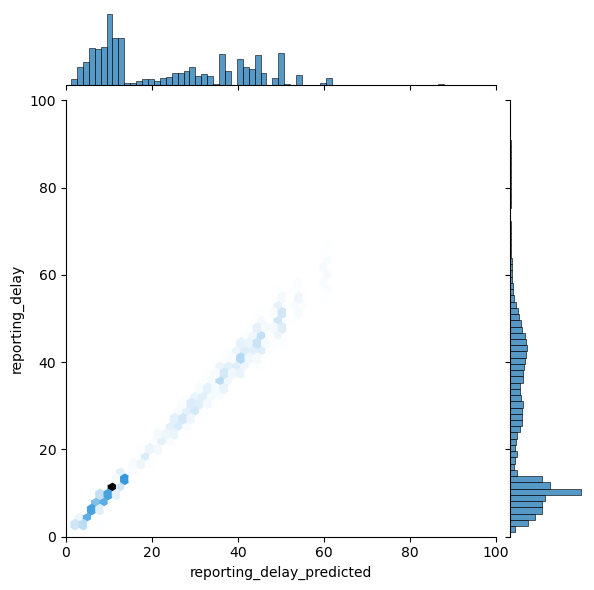

In [19]:
sns.jointplot(x='reporting_delay_predicted', y='reporting_delay', data=predicted_report_delays_joinedwithfeatures.query('reporting_delay_predicted < 100 and reporting_delay < 100'), kind='hex')
plt.xlim((0, 100))
plt.ylim((0, 100))

Ok, we have a good model of reporting delays, we can apply it to all the public data now

# Delay analysis final data preparation

First, combine multiple reports of the same incident so that I have one row per unique incident. Take first inspection and report date as the right date.

In [20]:
wofinishdatecolumn = 'ActualFinishDate' # 'WOClosedDate'

In [21]:
nodups = mergeddfpublic[['IncidentGlobalID','SRCategory','SRCreatedDate', 'InspectionDate',wofinishdatecolumn,'Risk_coded','RiskRating','Borough','InspectionTPCondition', 'InspectionTPStructure',
       'TreePointDBH']].groupby('IncidentGlobalID').agg(
    {'SRCreatedDate': 'min', 'InspectionDate': 'min', wofinishdatecolumn: 'min', 'SRCategory': 'first', 'Risk_coded': 'first', 'Borough': 'first', 'RiskRating': 'first', 'InspectionTPCondition': 'first', 'InspectionTPStructure': 'first',
       'TreePointDBH': 'first'}).reset_index()
nodups['inspection_delay'] = (nodups['InspectionDate'] - nodups['SRCreatedDate']).dt.total_seconds() / 3600 /24
nodups['work_delay'] = (nodups[wofinishdatecolumn] - nodups['InspectionDate']).dt.total_seconds() / 3600 /24
nodups[['SRCreatedDate','InspectionDate', wofinishdatecolumn]].describe(datetime_is_numeric=True)

,SRCreatedDate,InspectionDate,ActualFinishDate
count,552181,281992,129293
mean,2018-12-24 03:10:25.272691968,2019-01-24 20:10:01.489754624,2019-01-09 08:50:38.145823744
min,2015-02-28 14:03:49,1900-01-01 00:00:00,2014-11-01 04:00:00
25%,2017-04-07 19:40:00,2017-06-21 10:01:09.500000,2017-04-14 04:00:00
50%,2018-11-18 22:47:00,2018-12-21 09:41:59.500000,2019-01-19 05:00:00
75%,2020-08-18 21:17:00,2020-08-28 16:13:42.500000,2020-08-16 04:00:00
max,2022-09-01 02:05:31,2022-08-31 20:44:30,2022-08-31 04:00:00


In [22]:
nodups_rightdate = nodups[(nodups['SRCreatedDate'] >= '2017-06-30') & (nodups['SRCreatedDate'] < '2020-07-01')]

In [23]:
nodups_rightdate = nodups_rightdate[nodups_rightdate.SRCategory.isin(predicted_report_delays_joinedwithfeatures.SRCategory.unique())]

In [24]:
nodups_rightdate[['SRCreatedDate','InspectionDate', wofinishdatecolumn, 'work_delay']].describe(datetime_is_numeric=True)

,SRCreatedDate,InspectionDate,ActualFinishDate,work_delay
count,169881,109205,47047,47045.000000
mean,2018-12-01 08:13:19.511175424,2019-01-01 16:15:30.679007488,2019-04-17 00:19:43.865156096,132.252356
min,2017-06-30 00:02:43,1900-01-01 00:00:00,2015-03-29 04:00:00,-1457.377627
25%,2018-03-30 13:34:00,2018-04-16 04:00:00,2018-06-29 11:26:10,2.000000
50%,2018-10-26 13:30:25,2018-11-16 14:46:45,2019-03-05 05:00:00,26.794456
75%,2019-08-09 16:51:00,2019-09-11 08:48:06,2019-12-30 05:00:00,167.819931
max,2020-06-30 23:46:32,2022-08-25 16:04:55,2022-08-31 04:00:00,1857.000000
std,NaN,NaN,NaN,238.733926


In [25]:
nodups_rightdate.loc[:,'log_reporting_rate'] = model.predict(nodups_rightdate)
nodups_rightdate.loc[:,'reporting_delay'] = nodups_rightdate.eval('1/exp(log_reporting_rate)')

In [26]:
nodups_rightdate.count()

IncidentGlobalID         169881
SRCreatedDate            169881
InspectionDate           109205
ActualFinishDate          47047
SRCategory               169881
Risk_coded               169881
Borough                  169848
RiskRating               102559
InspectionTPCondition    108468
InspectionTPStructure    108466
TreePointDBH             106905
inspection_delay         109205
work_delay                47045
log_reporting_rate       106903
reporting_delay          106903
dtype: int64

In [27]:
nodups_rightdate.groupby(['SRCategory', 'Borough'])['reporting_delay', 'inspection_delay', 'work_delay'].median()

/tmp/ipykernel_5614/2028202929.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  nodups_rightdate.groupby(['SRCategory', 'Borough'])['reporting_delay', 'inspection_delay', 'work_delay'].median()


reporting_delay  inspection_delay  \
SRCategory          Borough                                            
Hazard              Bronx                 7.024545          1.963947   
                    Brooklyn             10.477734          3.959722   
                    Manhattan             5.484593          0.485382   
                    Queens                8.693329          1.853906   
                    Staten Island         5.361944          1.502153   
Illegal Tree Damage Bronx                30.487858          8.880150   
                    Brooklyn             45.337224         37.128084   
                    Manhattan            24.072812          4.347917   
                    Queens               37.807152         25.789086   
                    Staten Island        18.848486          3.852153   
Prune               Bronx                40.522270         13.216713   
                    Brooklyn             48.721781         10.871279   
                    Manhattan            31.800551          5.618750   
                    Queens               50.126144          8.888241   
                    Staten Island        24.932162          3.250000   
Remove Tree         Bronx                33.265712          6.816672   
                    Brooklyn             43.513636         13.959201   
                    Manhattan            26.159408          3.440972   
                    Queens               37.933595          6.906262   
                    Staten Island        22.282820          4.486366   
Root/Sewer/Sidewalk Bronx               207.357271         18.884167   
                    Brooklyn            309.321297         20.887147   
                    Manhattan           162.645513         15.874965   
                    Queens              256.566166         18.859514   
                    Staten Island       158.553671         20.829329   

                                   work_delay  
SRCategory          Borough                    
Hazard              Bronx            6.803200  
                    Brooklyn        11.746597  
                    Manhattan        0.416661  
                    Queens           4.693571  
                    Staten Island    8.590729  
Illegal Tree Damage Bronx          124.024612  
                    Brooklyn       117.022616  
                    Manhattan        5.000000  
                    Queens          71.214473  
                    Staten Island   98.000000  
Prune               Bronx           44.837234  
                    Brooklyn        91.626956  
                    Manhattan       87.786973  
                    Queens          21.000000  
                    Staten Island   55.000000  
Remove Tree         Bronx          184.381522  
                    Brooklyn       121.374225  
                    Manhattan       64.415000  
                    Queens         104.623935  
                    Staten Island  157.716308  
Root/Sewer/Sidewalk Bronx          493.721319  
                    Brooklyn       610.677674  
                    Manhattan      346.494219  
                    Queens         662.636238  
                    Staten Island  612.704734

In [28]:
#only looking at the inspected set
nodups_rightdate = nodups_rightdate.dropna(subset = ['reporting_delay'])

In [29]:
addressed = nodups_rightdate.groupby(['SRCategory', 'Borough'])['inspection_delay', 'work_delay'].agg(lambda x: 1-np.mean(np.isnan(x))).reset_index()
addressed

/tmp/ipykernel_5614/1414922349.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  addressed = nodups_rightdate.groupby(['SRCategory', 'Borough'])['inspection_delay', 'work_delay'].agg(lambda x: 1-np.mean(np.isnan(x))).reset_index()


,SRCategory,Borough,inspection_delay,work_delay
0,Hazard,Bronx,1.0,0.499764
1,Hazard,Brooklyn,1.0,0.486165
2,Hazard,Manhattan,1.0,0.886317
3,Hazard,Queens,1.0,0.567019
4,Hazard,Staten Island,1.0,0.699848
5,Illegal Tree Damage,Bronx,1.0,0.187273
6,Illegal Tree Damage,Brooklyn,1.0,0.124951
7,Illegal Tree Damage,Manhattan,1.0,0.424899
8,Illegal Tree Damage,Queens,1.0,0.171559
9,Illegal Tree Damage,Staten Island,1.0,0.340996


In [30]:
addressed = nodups_rightdate.groupby(['Risk_coded', 'Borough'])['inspection_delay', 'work_delay'].agg(lambda x: 1-np.mean(np.isnan(x))).reset_index()
addressed

/tmp/ipykernel_5614/4094152123.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  addressed = nodups_rightdate.groupby(['Risk_coded', 'Borough'])['inspection_delay', 'work_delay'].agg(lambda x: 1-np.mean(np.isnan(x))).reset_index()


,Risk_coded,Borough,inspection_delay,work_delay
0,A,Bronx,1.0,0.904192
1,A,Brooklyn,1.0,0.927007
2,A,Manhattan,1.0,0.981818
3,A,Queens,1.0,0.892935
4,A,Staten Island,1.0,0.956204
5,B,Bronx,1.0,0.857600
6,B,Brooklyn,1.0,0.860412
7,B,Manhattan,1.0,0.982418
8,B,Queens,1.0,0.866896
9,B,Staten Island,1.0,0.920705


In [31]:
# #turn inpsection and work delays into rows instead of columns
# addressed = addressed.melt(id_vars=['SRCategory', 'Borough'], value_vars=['inspection_delay', 'work_delay'], var_name='delay_type', value_name='percent_addressed')

In [32]:
# addressed = addressed.rename({'percent_addressed': 'Fraction addressed', 'delay_type': 'Action'}, axis=1)
# addressed.loc[:, 'Action'] = addressed.loc[:, 'Action'].str.replace('inspection_delay', 'Inspection').str.replace('work_delay', 'Work order')
# plot = sns.catplot(
#     data=addressed.query('SRCategory == "Hazard" and Action=="Work order"'), kind="bar",
#     x="Borough", y="Fraction addressed", hue="Action",
#     errorbar="sd", palette= ['green'], legend_out = False, #, alpha=.6, height=6
#     order = ['Manhattan', 'Queens', 'Staten Island', 'Bronx', 'Brooklyn']
# )
# legend = plot._legend
# legend.set_frame_on(False)
# plt.ylim(0, 1.1)
# plt.xlabel(None)
# plt.savefig(f'plots/{filesavelabel}hazard_fractionaddressed.pdf', bbox_inches='tight')

# Plotting

<!-- ## What fraction of incidents are actually addressed -->

## Delays conditional on addressed

In [33]:
# plot_bar_by_type(nodups_rightdate, typecol = 'SRCategory', othergroupby = 'Borough', impute_missing_work_order = False, label = f'{filesavelabel}')

In [34]:
nodups_rightdate.head()

,IncidentGlobalID,SRCreatedDate,InspectionDate,ActualFinishDate,SRCategory,Risk_coded,Borough,RiskRating,InspectionTPCondition,InspectionTPStructure,TreePointDBH,inspection_delay,work_delay,log_reporting_rate,reporting_delay
0,0000100E-70B3-4F0E-A2FD-A5A7F0B152BA,2020-06-30 03:03:00,2020-06-30 15:20:00,2020-07-06 04:00:00,Hazard,D,Brooklyn,6.0,Fair,Full,29.0,0.511806,5.527778,-2.349691,10.482330
1,00002A8F-3226-4C3C-99DA-7747FC434225,2018-08-15 23:42:00,2018-08-21 11:33:50,2019-04-01 23:30:19,Remove Tree,D,Staten Island,6.0,Poor,Full,16.0,5.494329,223.497558,-2.916103,18.469172
5,0000772C-2DFE-462C-B2AA-222511B821ED,2017-10-11 11:41:00,2017-10-17 11:51:48,NaT,Hazard,C,Bronx,9.0,Dead,Full,22.0,6.007500,NaN,-2.221548,9.221593
13,0000F368-B6B4-459E-BE57-5D838A2698D7,2020-06-29 23:19:00,2020-06-30 12:19:10,2020-06-30 04:00:00,Hazard,B,Brooklyn,10.0,Critical,Full,24.0,0.541782,-0.346644,-1.171355,3.226361
22,0001FF96-B046-49DF-B9B9-880065DD55A6,2018-11-01 15:45:00,2018-11-05 10:57:52,NaT,Remove Tree,D,Queens,3.0,Good,Full,2.0,3.800602,NaN,-3.798024,44.612949


In [35]:
nodups_rightdate = nodups_rightdate.sort_values(by = 'Risk_coded', ascending = True)

In [36]:
import helpers

Overall split by typecol but not other group


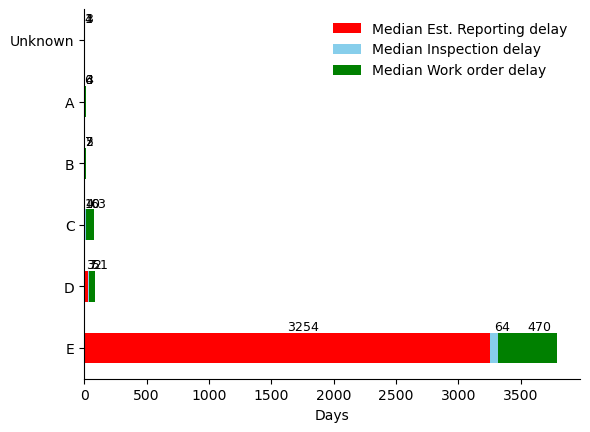

A


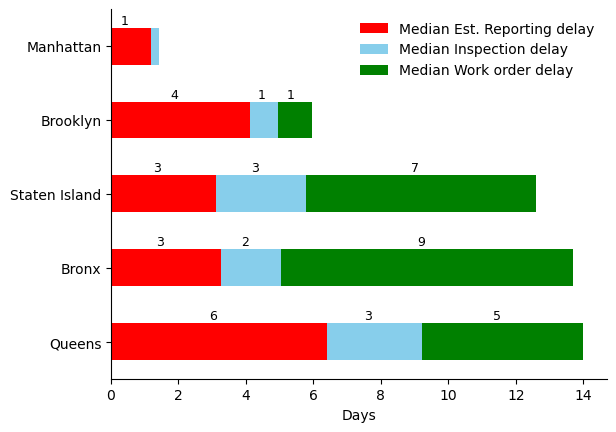

B


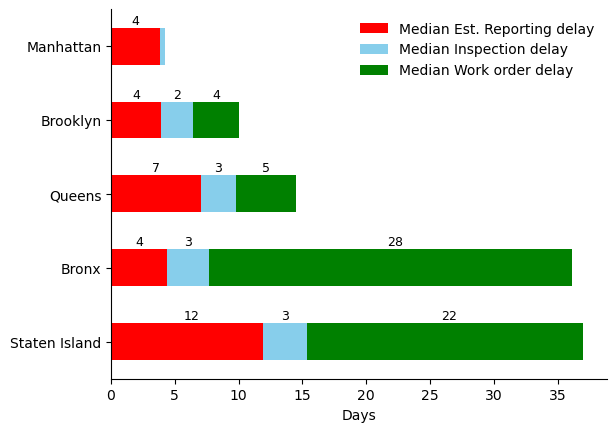

C


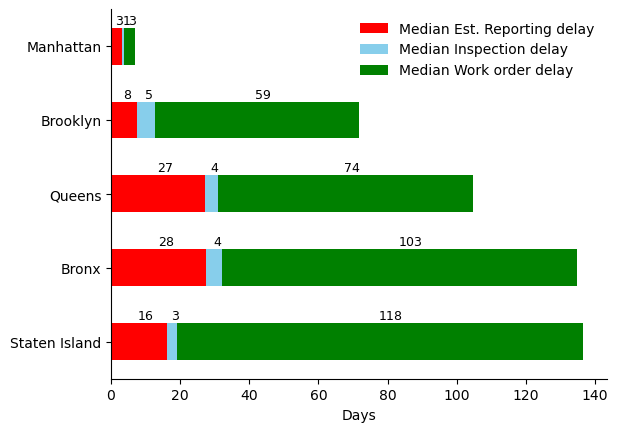

D


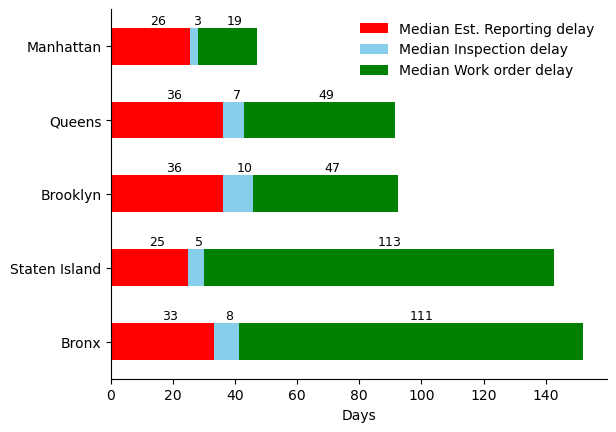

E


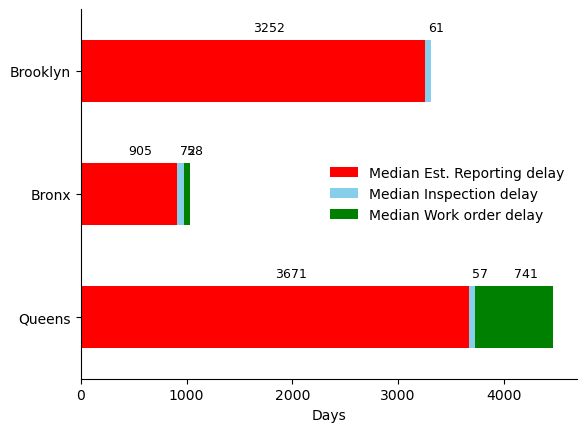

Unknown


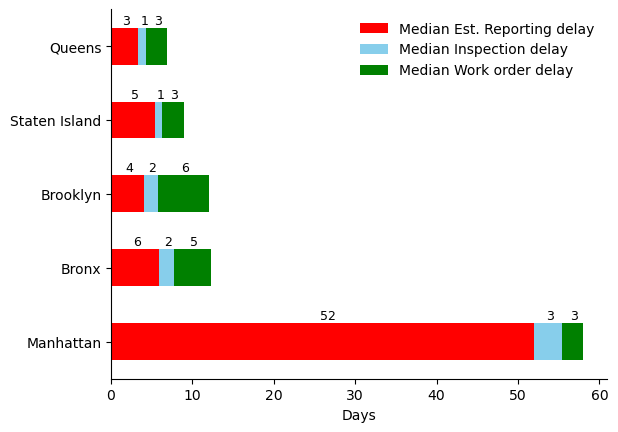

In [37]:
helpers.plot_bar_by_type(nodups_rightdate.dropna(subset = ['inspection_delay']), typecol = 'Risk_coded', othergroupby = 'Borough', impute_missing_work_order = False, label = f'{filesavelabel}risk_notimputed_')

Overall split by typecol but not other group


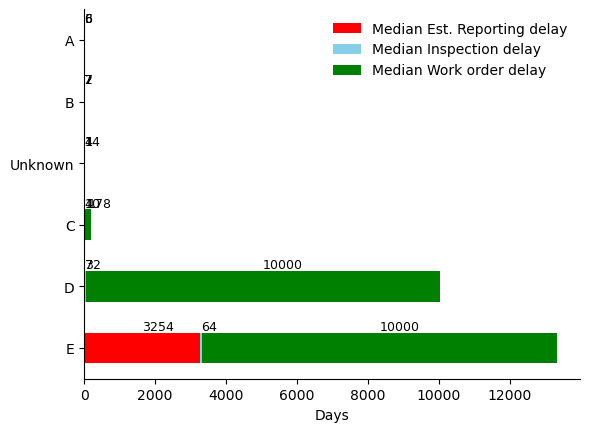

A


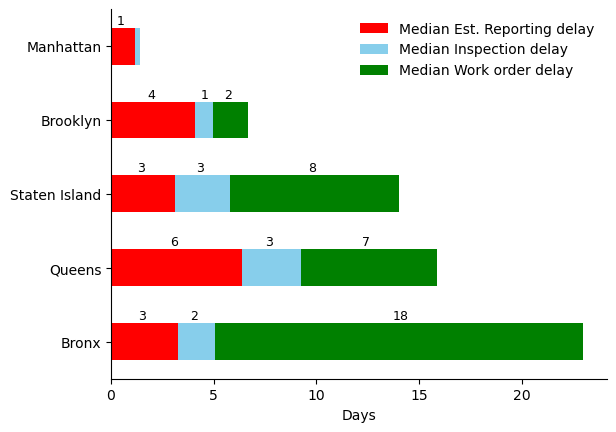

B


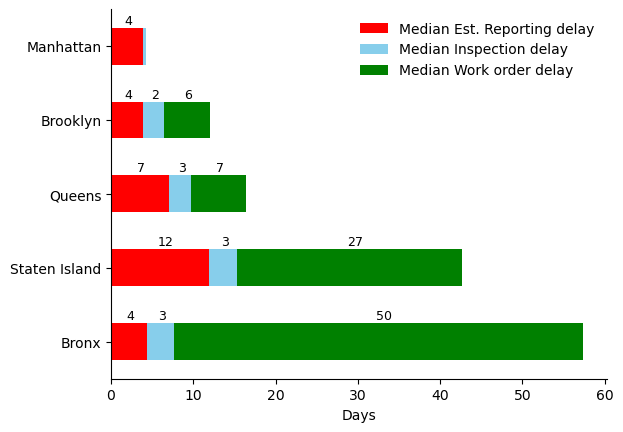

C


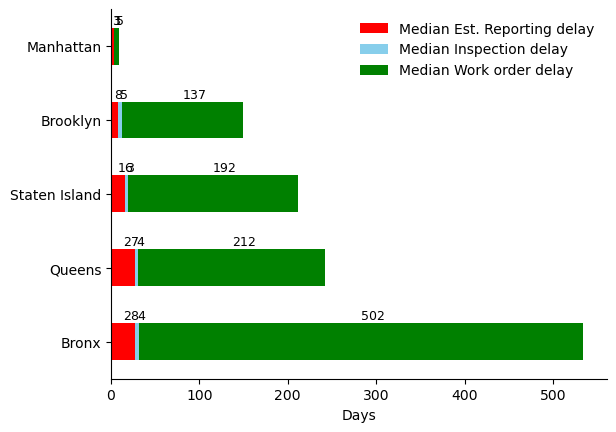

D


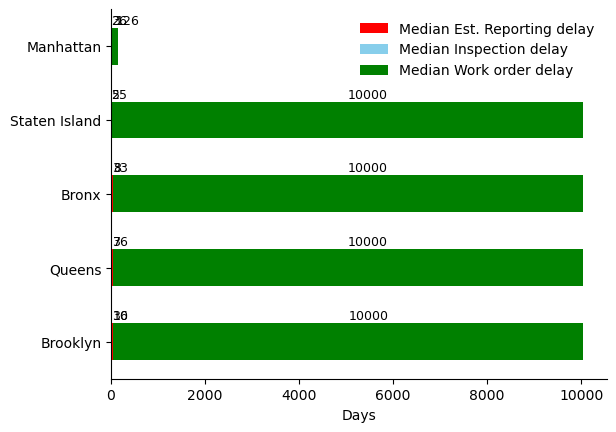

E


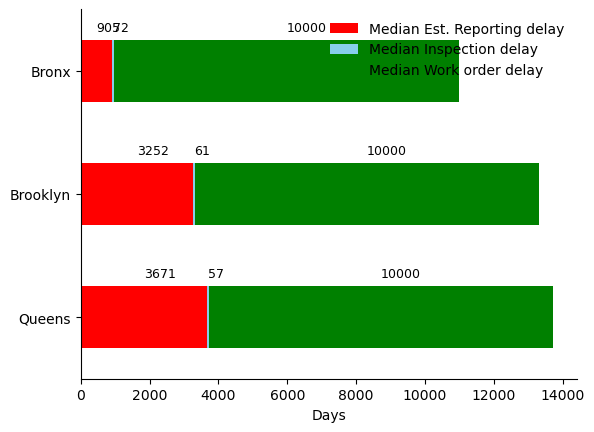

Unknown


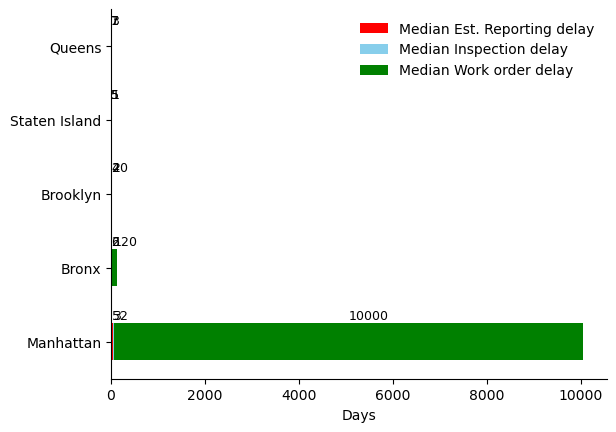

In [38]:
helpers.plot_bar_by_type(nodups_rightdate.dropna(subset = ['inspection_delay']), typecol = 'Risk_coded', othergroupby = 'Borough', impute_missing_work_order = True, label = f'{filesavelabel}risk_imputed_')

# function that does a better equity analysis
	1. Create a function that takes a dataframe that I want and:
		a. Creates a "city average delay" in terms of reporting, inspection, and work order
		b. Creates a measure of "overall extra delay" compared to city level
		c. Plots this by Borough


In [48]:
import helpers_equity

In [66]:
# del nodups_rightdate['reporting_delay_citywideprediction']
# del nodups_rightdate['inspection_delay_citywideprediction']
# del nodups_rightdate['work_delay_citywideprediction']

In [67]:
dfloc = nodups_rightdate.copy()

In [68]:
# equity_analysis(df, delay_kinds = ['overall_extra_delay', 'risk_weighted_extra_delay']
#                     , statistics = ['median', 'sum', 'percent'])

In [82]:
def get_city_average_as_median_per_col(df, groupbycols = ['SRCategory', 'Risk_coded']):
    medians = df.groupby(groupbycols)['reporting_delay', 'inspection_delay', 'work_delay'].median().reset_index()
    medians = medians.rename(columns = {'reporting_delay': 'reporting_delay_citywideprediction', 'inspection_delay': 'inspection_delay_citywideprediction', 'work_delay': 'work_delay_citywideprediction'})
    df = pd.merge(df, medians, on = groupbycols, how = 'left')
    df.loc[:,'true_delay_prediction'] = df.eval('reporting_delay_citywideprediction + inspection_delay_citywideprediction + work_delay_citywideprediction')
    df.loc[:,'overall_extra_delay'] = df.eval('reporting_delay + inspection_delay + work_delay - true_delay_prediction')
    return df

def get_city_average_as_median_overall(df, groupbycols = ['SRCategory', 'Risk_coded']):
    df.loc[:,'true_delay'] = df['reporting_delay'] + df['inspection_delay'] + df['work_delay']
    medians = df.groupby(groupbycols)['true_delay'].median().reset_index()
    medians = medians.rename(columns = {'true_delay': 'true_delay_prediction'})
    df = pd.merge(df, medians, on = groupbycols, how = 'left')
    df.loc[:,'overall_extra_delay'] = df.eval('true_delay - true_delay_prediction')
    return df

# def get_city_average_as_mean_per_col(df, groupbycols = ['SRCategory', 'Risk_coded']):
#     means = df.groupby(groupbycols)['reporting_delay', 'inspection_delay', 'work_delay'].mean().reset_index()
#     means = means.rename(columns = {'reporting_delay': 'reporting_delay_citywideprediction', 'inspection_delay': 'inspection_delay_citywideprediction', 'work_delay': 'work_delay_citywideprediction'})
#     df = pd.merge(df, means, on = groupbycols, how = 'left')
#     df.loc[:,'overall_extra_delay'] = df.eval('reporting_delay - reporting_delay_citywideprediction + inspection_delay - inspection_delay_citywideprediction + work_delay - work_delay_citywideprediction')
#     return df

# def get_city_average_as_mean_overall(df, groupbycols = ['SRCategory', 'Risk_coded']):
#     df.loc[:,'true_delay'] = df['reporting_delay'] + df['inspection_delay'] + df['work_delay']
#     means = df.groupby(groupbycols)['true_delay'].mean().reset_index()
#     means = means.rename(columns = {'true_delay': 'true_delay_prediction'})
#     df = pd.merge(df, means, on = groupbycols, how = 'left')
#     df.loc[:,'overall_extra_delay'] = df.eval('true_delay - true_delay_prediction')
    return df

A
overall_extra_delay percent


/mnt/c/Users/Nikhi/OneDrive/src/2022_underreporting_public_actual/nyc/impact_analysis/helpers_equity.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/mnt/c/Users/Nikhi/OneDrive/src/2022_underreporting_public_actual/nyc/impact_analysis/helpers_equity.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  for col in reversed(delay_kinds):
/mnt/c/Users/Nikhi/OneDrive/src/2022_underreporting_public_actual/nyc/impact_analysis/helpers_equity.py:54: SettingWithCopyWarning: 
A value is trying to be set on a cop

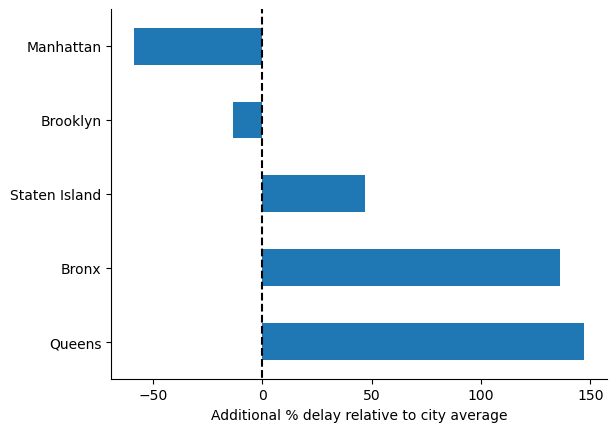

B
overall_extra_delay percent


/mnt/c/Users/Nikhi/OneDrive/src/2022_underreporting_public_actual/nyc/impact_analysis/helpers_equity.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/mnt/c/Users/Nikhi/OneDrive/src/2022_underreporting_public_actual/nyc/impact_analysis/helpers_equity.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  for col in reversed(delay_kinds):
/mnt/c/Users/Nikhi/OneDrive/src/2022_underreporting_public_actual/nyc/impact_analysis/helpers_equity.py:54: SettingWithCopyWarning: 
A value is trying to be set on a cop

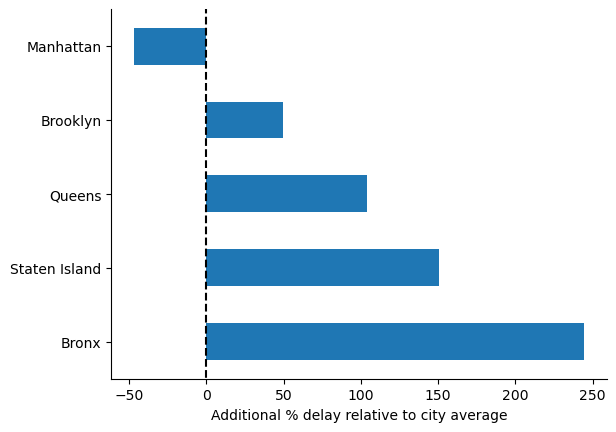

C
overall_extra_delay percent


/mnt/c/Users/Nikhi/OneDrive/src/2022_underreporting_public_actual/nyc/impact_analysis/helpers_equity.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/mnt/c/Users/Nikhi/OneDrive/src/2022_underreporting_public_actual/nyc/impact_analysis/helpers_equity.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  for col in reversed(delay_kinds):
/mnt/c/Users/Nikhi/OneDrive/src/2022_underreporting_public_actual/nyc/impact_analysis/helpers_equity.py:54: SettingWithCopyWarning: 
A value is trying to be set on a cop

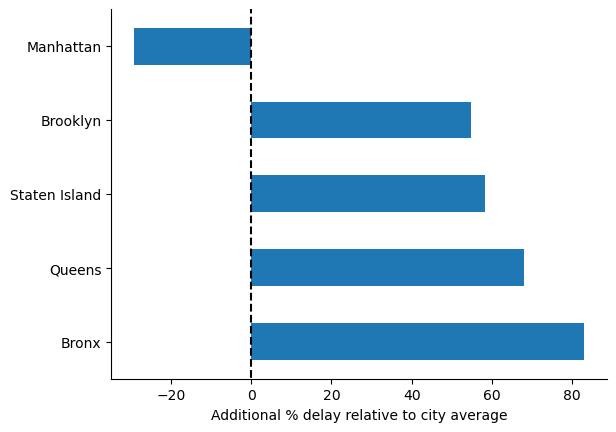

In [85]:
for risk_code in ['A', 'B', 'C']:
    print(risk_code)
    dflocc = get_city_average_as_median_overall(dfloc.copy(), groupbycols = ['Risk_coded'])
    df, dffbar = helpers_equity.equity_analysis(dflocc.query(f'Risk_coded == "{risk_code}"'), filesavelabel = f'risk{risk_code}'
                        , delay_kinds = ['overall_extra_delay']
                        , statistics = ['percent']
                        )

A
overall_extra_delay percent


/mnt/c/Users/Nikhi/OneDrive/src/2022_underreporting_public_actual/nyc/impact_analysis/helpers_equity.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/mnt/c/Users/Nikhi/OneDrive/src/2022_underreporting_public_actual/nyc/impact_analysis/helpers_equity.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  def equity_analysis(df, delay_kinds = ['overall_extra_delay', 'risk_weighted_extra_delay']
/mnt/c/Users/Nikhi/OneDrive/src/2022_underreporting_public_actual/nyc/impact_analysis/helpers_equity.py:45: Sett

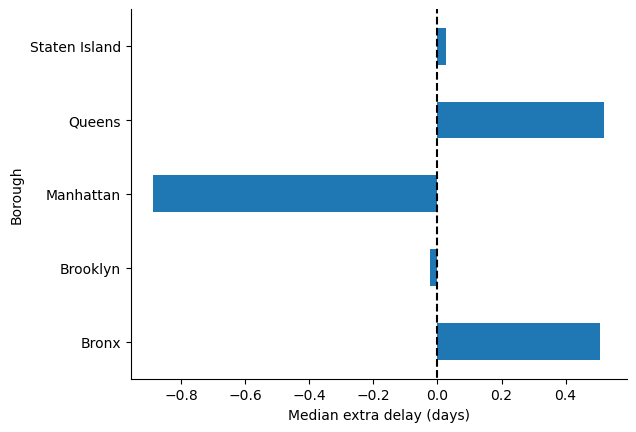

B
overall_extra_delay percent


/mnt/c/Users/Nikhi/OneDrive/src/2022_underreporting_public_actual/nyc/impact_analysis/helpers_equity.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/mnt/c/Users/Nikhi/OneDrive/src/2022_underreporting_public_actual/nyc/impact_analysis/helpers_equity.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  def equity_analysis(df, delay_kinds = ['overall_extra_delay', 'risk_weighted_extra_delay']
/mnt/c/Users/Nikhi/OneDrive/src/2022_underreporting_public_actual/nyc/impact_analysis/helpers_equity.py:45: Sett

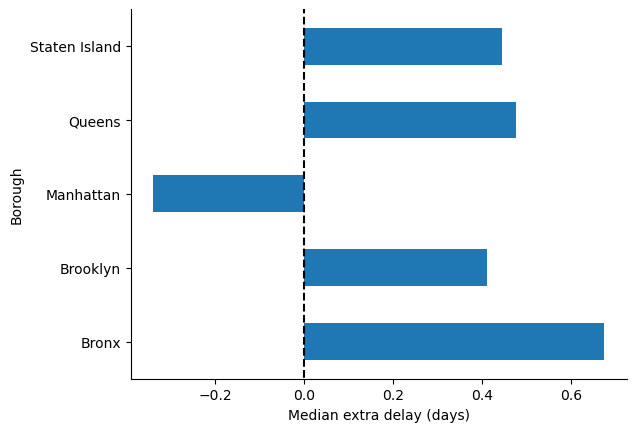

C
overall_extra_delay percent


/mnt/c/Users/Nikhi/OneDrive/src/2022_underreporting_public_actual/nyc/impact_analysis/helpers_equity.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/mnt/c/Users/Nikhi/OneDrive/src/2022_underreporting_public_actual/nyc/impact_analysis/helpers_equity.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  def equity_analysis(df, delay_kinds = ['overall_extra_delay', 'risk_weighted_extra_delay']
/mnt/c/Users/Nikhi/OneDrive/src/2022_underreporting_public_actual/nyc/impact_analysis/helpers_equity.py:45: Sett

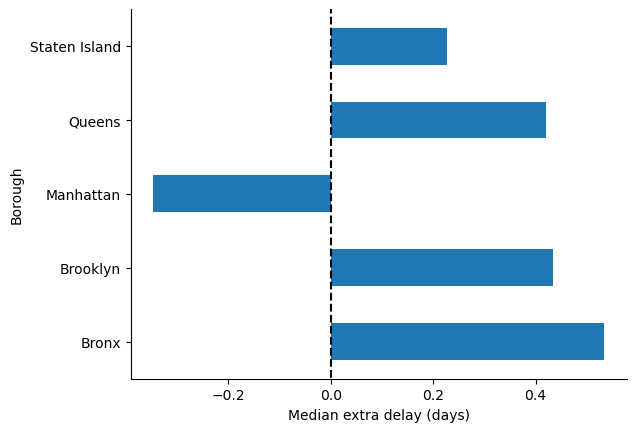

In [78]:
for risk_code in ['A', 'B', 'C']:
    print(risk_code)
    dflocc = get_city_average_as_median_overall(dfloc.copy())
    df, dffbar = helpers_equity.equity_analysis(dflocc.query(f'Risk_coded == "{risk_code}"')
                        , delay_kinds = ['overall_extra_delay']
                        , statistics = ['percent']
                        )

/tmp/ipykernel_5614/4056750940.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  medians = df.groupby(groupbycols)['reporting_delay', 'inspection_delay', 'work_delay'].median().reset_index()


risk_weighted_extra_delay percent


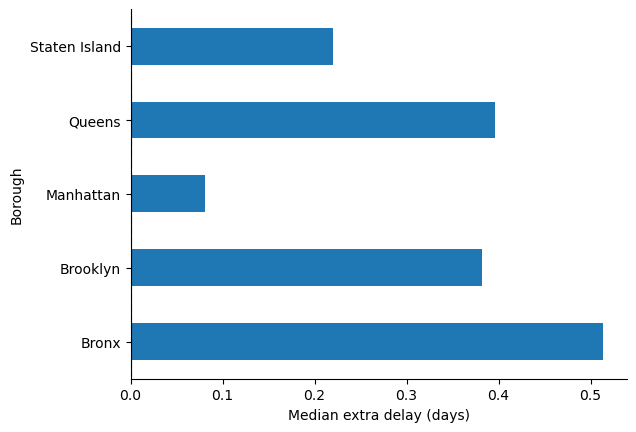

risk_weighted_extra_delay sum


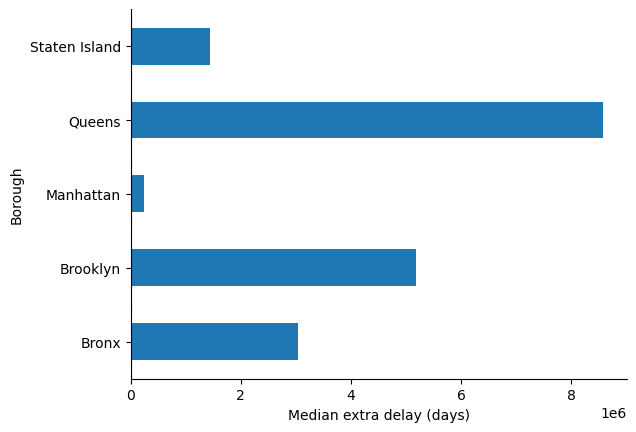

risk_weighted_extra_delay median


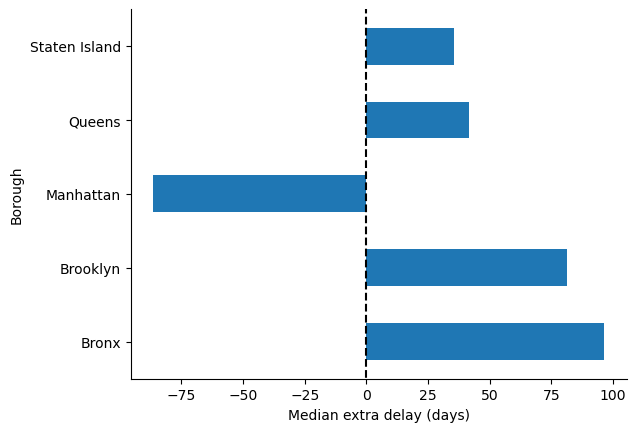

overall_extra_delay percent


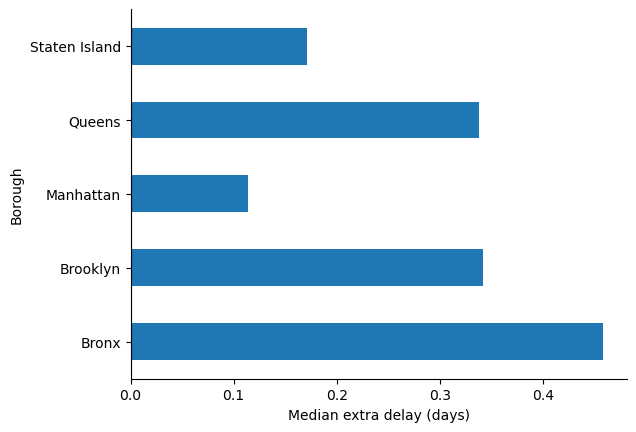

overall_extra_delay sum


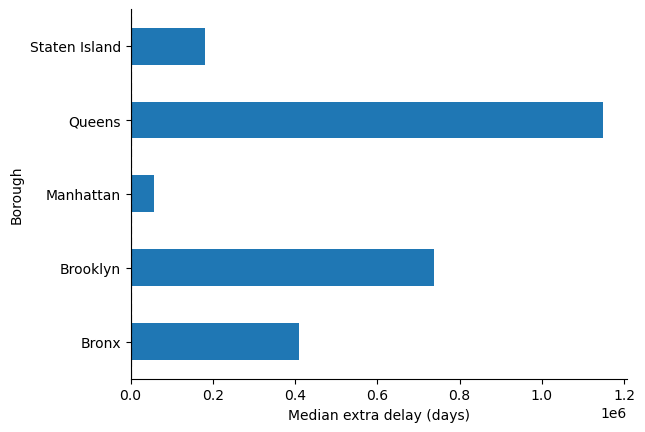

overall_extra_delay median


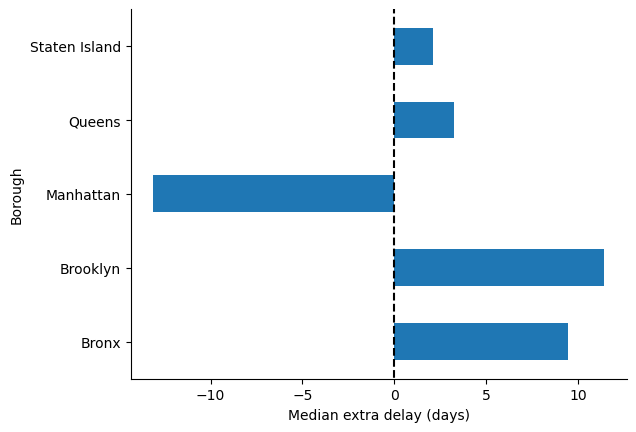

,Borough,overall_extra_delay
0,Bronx,9.455475
1,Brooklyn,11.410707
2,Manhattan,-13.132473
3,Queens,3.271234
4,Staten Island,2.094698


In [41]:
df, dffbar = equity_analysis(nodups_rightdate)
dffbar.head()

risk_weighted_extra_delay percent


/tmp/ipykernel_5614/4056750940.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  medians = df.groupby(groupbycols)['reporting_delay', 'inspection_delay', 'work_delay'].median().reset_index()


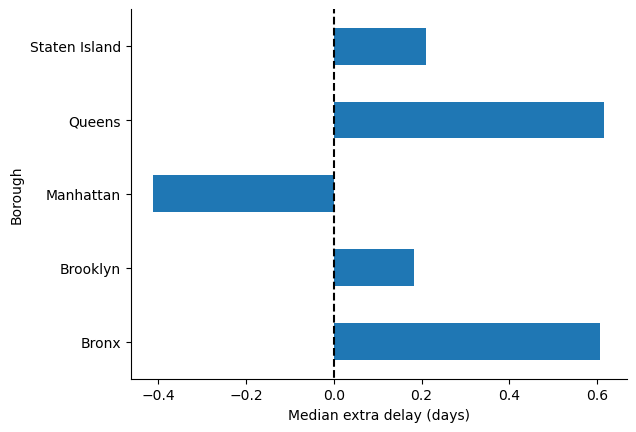

risk_weighted_extra_delay sum


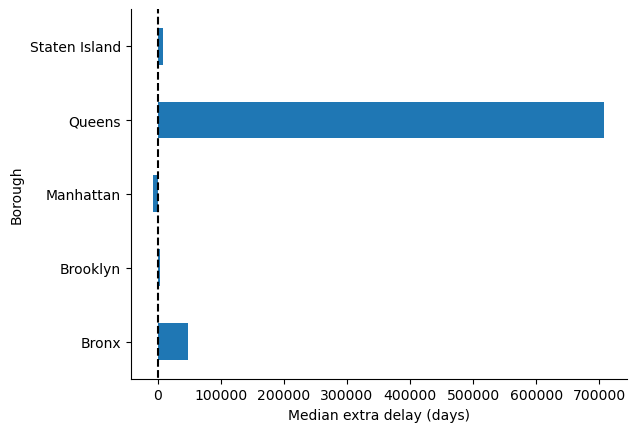

risk_weighted_extra_delay median


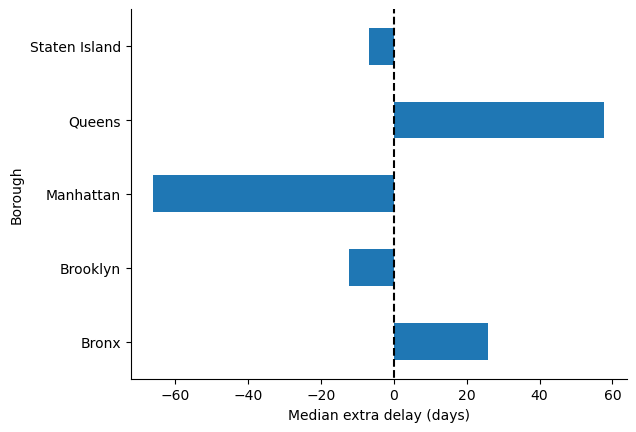

overall_extra_delay percent


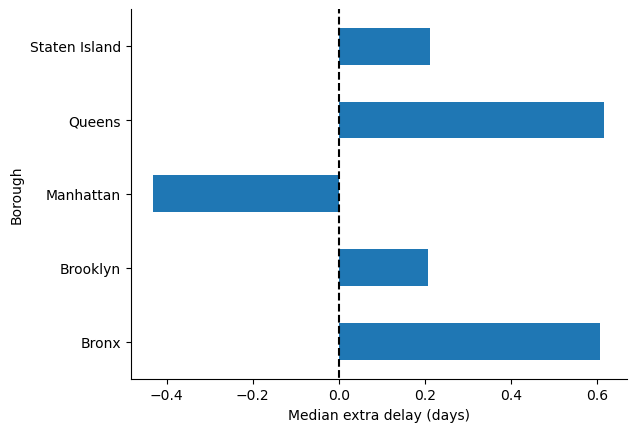

overall_extra_delay sum


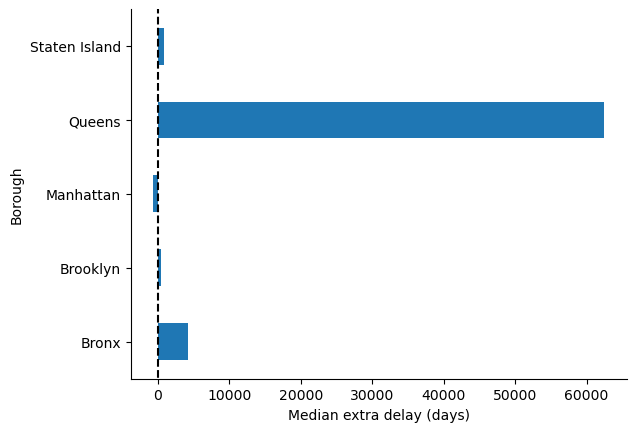

overall_extra_delay median


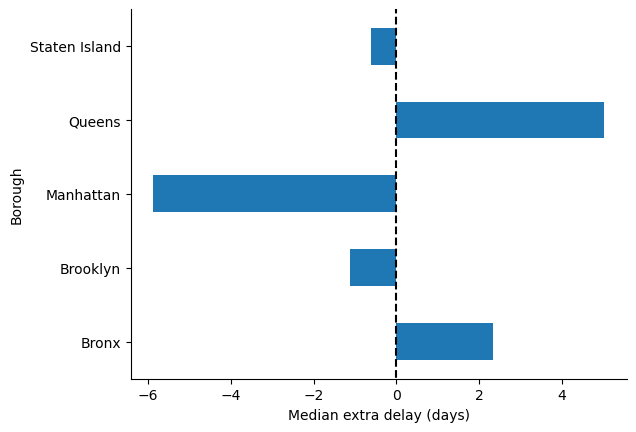

,Borough,overall_extra_delay
0,Bronx,2.340059
1,Brooklyn,-1.113756
2,Manhattan,-5.877251
3,Queens,5.017492
4,Staten Island,-0.605442


In [42]:
df, dffbar = equity_analysis(nodups_rightdate.query('Risk_coded == "A"'))
dffbar.head()